#  Predicting Root Causes of Safety Observations

## Classifying Safety Observations using Natural Language Learning Process to predict root causes.

In [1]:
# importing necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
%matplotlib inline

## 1. Importing Data

The data which I am using here is a dump from the Safety Observation System of a Major Company. The each row of data consists of the observation description along with pre-selected category and root cause (Classes).

The objective of this program would be to develop a Machine Learning Model which would be able to predict the root cause based on this historical data for any new observation. By implication this exercise is an Natural Language Processing Exercise. As we will be extracting features from text (Observation Description) and using those for training our classification model

The overall plan includes

1. Cleaning the data by removing stops and performing EDA.
2. Feature extraction to arrive on most important features.
3. Training our different models and tuning hyper-parameters.
4. Evaluation of Models and selection of best model.
5. Summary and Future action.

In [2]:
# let us import the data
df_obs = pd.read_csv('ehs_obs_data.csv')
df_obs.head()

c:\users\aa-minhaj\sklearn-venv\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,UA/UC,Observation,Sub-Category
0,Electrically Unsafe (Safety Hazard),worker used drilling machine without green tag.,NaN
1,Electrically Unsafe (Safety Hazard),Worker used a plug top for multiple electrica...,No Plug top
2,Electrically Unsafe (Safety Hazard),worker use drilling machine at site without gr...,NaN
3,Electrically Unsafe (Safety Hazard),Site supervisor is not available at site whi...,NaN
4,Electrically Unsafe (Safety Hazard),worker use electric grinder without green tag.,No Inspection Done


In [3]:
#Let us check the no of columns and rows

print(f'The number of columns in the dataset is {df_obs.shape[1]} and the no of rows is {df_obs.shape[0]}')

The number of columns in the dataset is 3 and the no of rows is 1028493


The target variable here will be 'Sub-Category' and the input variable will be 'Observation'

## 2. Data Cleaning and Wrangling

In this step we will try to 

1. Bring all words on same case (lower case).
2. Detect the missing values and treat them accordingly.
3. Drop various Stop words which don't add any information to the model.

In [4]:
#Let us first bring in all the required modules

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [5]:
#lets first drop the 'UA/UC' Column which is not required for this exercise.

df_obs.drop('UA/UC', axis = 1, inplace = True)

In [6]:
df_obs.head()

,Observation,Sub-Category
0,worker used drilling machine without green tag.,NaN
1,Worker used a plug top for multiple electrica...,No Plug top
2,worker use drilling machine at site without gr...,NaN
3,Site supervisor is not available at site whi...,NaN
4,worker use electric grinder without green tag.,No Inspection Done


In [7]:
# Lets check the missing values

df_obs.isnull().sum()

Observation     961881
Sub-Category    996100
dtype: int64

Looks like we have lots of blank rows. However, this may be due to faulty data extraction process and we can easily drop these without losing any meaningful information.

In [8]:
# dropping values
df_obs.dropna(subset = ['Observation'], axis = 0, inplace = True)

In [9]:
# Lets check how many values are missing in target variable after dropping missing feature rows
df_obs.shape[0], df_obs.isnull().sum()

(66612,
 Observation         0
 Sub-Category    34219
 dtype: int64)

We can see that we missing lables for almost half of the data. Now this leaves a lot of room for improvement in data collection and labelling process. Unfortunately, we have to leave out all these rows from our modelling.

In [10]:
#droping values
df_obs.dropna(subset = ['Sub-Category'], axis = 0, inplace = True)
df_obs.shape[0], df_obs.isnull().sum()

(32393,
 Observation     0
 Sub-Category    0
 dtype: int64)

So, in the end we are now left with 32,393 Nos of individual observations

In [11]:
# Lets check for the duplicates in the observation column

df_obs.duplicated(subset = ['Observation'], keep = 'first').sum()

6806

Looks like we have quite a few number of duplicated observation data. It would be better to drop these duplicate columns to avoid any bias in our modelling.

In [12]:
df_obs.drop_duplicates(subset = 'Observation', keep = 'first', ignore_index = True, inplace = True)

In [13]:
# final size of the dataframe
print(f'The number of columns in the dataset is {df_obs.shape[1]} and the no of rows is {df_obs.shape[0]}')

The number of columns in the dataset is 2 and the no of rows is 25587


## Data Cleaning and Wrangling - Summary

* We dropped the null values and duplicated observations to reduce the dimensions of the data
* This also ensures that we avoid assigining higher weightage to certain duplicated observations at the time of feature extraction.
* We also dropped UA/UC columns as we want to explore this dataset purely from NLP perspective.

## 3. Exploratory Data Analysis and Feature Extraction

In this step, we will

1. Remove punctuation marks and anyother extra space.
2. Lemmatize all the words so that different words stemming from same root word are not counted as separate features.
3. Label Encode our target variables
4. Check the weight of each class and discuss on the possibility of the oversampling, Undersampling or resampling
5. Extract features from our observation text using tfidf method.

First we will remove the punctuation marks and extra spaces in the string

In [14]:
numbers = map(str, list(range(0, 100)))
for num in numbers:
    df_obs.Observation =  df_obs.Observation.str.replace(num, ' ', regex = False)
special_charecters = ['?', '#', '-', "'", '&', '/', '.', ',', '(', ')', ':',';']
for char in special_charecters:
     df_obs.Observation =  df_obs.Observation.str.replace(char, ' ', regex = False)

In [15]:
df_obs.Observation = df_obs.Observation.apply(lambda x: " ".join(x.split()))
df_obs.Observation = df_obs.Observation.str.strip()

Lets lemmatize our observation text for better results. 

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

We will use WordNetLemmatizer from NTLK library for this purpose

In [16]:
wordlemmatize = WordNetLemmatizer()

In [17]:
def lemmatize_text(word_list):
    lem_word_list = [wordlemmatize.lemmatize(word, pos = 'v') for word in word_list.split()]
    new_lem_word_list = [wordlemmatize.lemmatize(word) for word in lem_word_list]
    return " ".join(new_lem_word_list)

In [18]:
df_obs.Observation = df_obs.Observation.apply(lemmatize_text)

In [19]:
#Lets check our cleaned dataframe

df_obs.sample(10)

,Observation,Sub-Category
15734,Jcb operataor engage without screen,Workmen engaged without screening/ Induction
24276,Adequate approach be not provide to go inside ...,Unsafe/ Blocked Access & Egress
10713,Back fill be not do near of the SPS wall,No/ Improper Backfilling
5833,Single core wire be use for electrical connection,Unsafe Electrical connections/Practices ...
5778,Electrical wire find without pluck top,Unsafe Electrical connections/Practices ...
16349,workman Mr Aniket kailash be find to be engage...,Workmen engaged without screening/ Induction
1003,insulation provide to damage electrical cable ...,Cable Insulation Issue/Bare Wires ...
17352,Backfilling be not do yesterday,No/ Improper Backfilling
434,worker use electric cutter without guard,Unsafe Electrical connections/Practices ...
10885,Trench be keep unattended after lower the pipe...,No Hard Barricading


If you watch closely lemmatization has taken affect on many words for ex- against index 7778 the word 'been' has been stemmed to 'be', the word 'kept' has been changed back to 'keep' at 7656. In reality, these words would have been extracted as separate features thereby increasing the overall feature dimension

Now lets encode out target variables to prepare them for modeling

In [20]:
labelencoder = LabelEncoder()
df_obs['Sub-Category'] = labelencoder.fit_transform(df_obs['Sub-Category'])

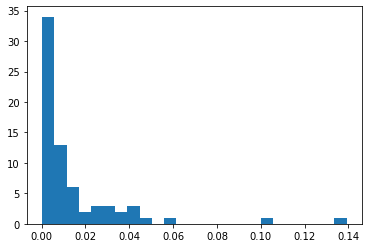

In [21]:
plt.hist(df_obs['Sub-Category'].value_counts(normalize = True), bins = 25,);

This shows that our classes have quite severe imbalance. And this can impact our final model's performance. Instead of opting for any sampling approach lets try to model our data using imbalanced classes by maintaining class imbalance in the train and test split. We will use class_weight feature wherever available to penalize the imbalance. Also lets save all our label names and codes for future references

In [22]:
label_codes = pd.DataFrame(labelencoder.classes_).reset_index()
label_codes.columns = ['Label Code', 'Label']
label_codes.head()

,Label Code,Label
0,0,No Plug top
1,1,Backhoe Operator engaged without screening and...
2,2,Cable Insulation Issue/Bare Wires ...
3,3,"Cable issues(Routing, Sub-standard etc)"
4,4,Cable/Wire run across accessway


Next and probably most important step for modelling is to extract features from text data. Now there are many methods to acheive this objective but the most important from all is Term Frequency and Inverse Document Frequnecy Method.

In information retrieval, tf–idf, TF*IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

Another important term that you will come across would be N-grams. In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. When the items are words, n-grams may also be called shingles.

Using Latin numerical prefixes, an n-gram of size 1 is referred to as a "unigram"; size 2 is a "bigram" (or, less commonly, a "digram"); size 3 is a "trigram".

For example a feature - 'Safety' is unigram whereas a feature 'Safety Helmet' would be bigram 

In [23]:
# So lets instantiate our tfidfvectorizer by setting feature output for both unigrams and bigrams and Stop words from English
tfidf = TfidfVectorizer(ngram_range = (1,2),
                        stop_words = 'english',
                        min_df = 10,
                       )

The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Also, I have set min_df = 10, which means words that occurred in too few documents, in this case less than 10, should be filtered out.

I would higly recommend the reader to go through sklearn's working with text data resources. https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

At this point it would be prudent to first split our data into training and test sets and then applying fit_tranform only on the training set using the fit to tranform our test set. 

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_obs.Observation, df_obs['Sub-Category'],
                                                    test_size = 0.3, random_state = 1000,
                                                    stratify = df_obs['Sub-Category']
                                                   )

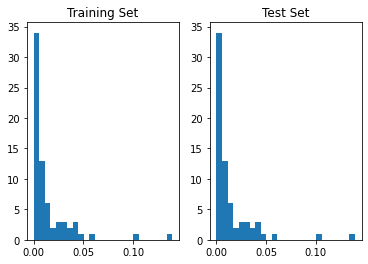

In [26]:
#Lets check the class imbalance in both of train and test splits

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(y_train.value_counts(normalize = True), bins = 25,);
ax1.set(title = 'Training Set');
ax2.hist(y_test.value_counts(normalize = True), bins = 25,);
ax2.set(title = 'Test Set');

We have used the stratify attribute in train_test_split. So, the class distribution is maintained in train and test splits. we can move ahead and extract feature using our tfidfvectorizer class instance

In [27]:
features = tfidf.fit_transform(X_train, y_train).toarray()

print(f'The feature matrix contains {features.shape[0]} observations with {features.shape[1]} features')

The feature matrix contains 17910 observations with 2582 features


In [28]:
# Let us create the feature matrix for our future reference

feature_matrix = pd.DataFrame(data = features, columns = tfidf.get_feature_names())
feature_matrix.head()

,aaa,absence,access,access approach,access area,access arrangement,access available,access block,access egress,access filter,...,workplace screen,wtp,xi,xi im,yadav,yadav engage,yard,zone,zone area,zone site
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


That's a lot of features and it would be tedious and iefficient to fit all these features to the model. So, it would be better at this stage that to select features that are most important and that can acheive maximum gains for our models.

We will do this by computing chi-squared stats between each non-negative feature and class.

This score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.

In [29]:
from sklearn.feature_selection import chi2

In [30]:
# running chi2 test and storing the chi statistics and p_value

chi2_features, p_value = chi2(feature_matrix, y_train)

In [31]:
# forming the dataframe with features, chi statistics, and p_value

df_chi2_features = pd.DataFrame(data = [feature_matrix.columns, chi2_features, p_value]).T
df_chi2_features.columns = ['Feature_name', 'Chi value', 'p_value']

Now, this is the time for final feature selection. We form our hyothesis here with the significance level of alpha = 0.05.

Thus our Null hypothesis is that there is no significance association between the input variable and target variable. While our alternate hypothesis is that there is significance association between the input variable and target variable.

Consequently, we will select only those features which have p_value less that 0.05 (Significance level), so that we can reject our null hypothesis.

In [32]:
df_chi2_features.loc[df_chi2_features['p_value']< 0.05].sort_values(by = 'p_value', ascending = True)

,Feature_name,Chi value,p_value
2,access,2632.696183,0.0
898,harness,3083.436262,0.0
925,height pas,2170.761754,0.0
930,helmet,6901.796873,0.0
939,hoe,2082.010137,0.0
...,...,...,...
2124,slab area,89.87553,0.046525
1847,ram nagar,89.862447,0.046616
202,block,89.811884,0.04697
277,cable observe,89.54714,0.048858


Here we can see that we have around 1303 features which are statistically significant thus we can retain them for further modeling. Accordingly, we will drop all other features from our feature matrix.

In [33]:
final_features = df_chi2_features.loc[df_chi2_features['p_value']< 0.05].sort_values(by = 'p_value', ascending = True)
final_feature_columns = list(final_features['Feature_name'])
len(final_feature_columns)

1303

## Exploratory Data Analysis and Feature Extraction -Summary

* We realised that our data consists of highly imbalanced classes. We tried to take that into consideration by splitting our data using startified option under train_test_split function.
* This ensured that we maintained the equal amount of imbalance in our test as well as train split.
* Next step was to prepare the text data for further feature extraction. We applied various transformations such as lemmatization amd acheiving homogenization by converting all words into lower case.
* We encoded our target variables.
* Finally, we used tfidfvectorizer to extract features from our text data. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.
* As usual we fitted and transformed tfidfvectorizer over train data and used that fiited model to transform our test data.
* Finally, we perfromed chi2 test to extract the best associated features with p-value less than 0.05.

## 4. Model Evaluation and Selection

In this step, we will,

1. Drop columns which we rejected based on hypothesis testing.
2. Use GridSearchCV to iterate through the models and parameters.
3. Select the best model and subsequently the best values for hyperparameters.
4. Also, we will try to reach best compromise over the precision and recall values.

In [34]:
final_feature_matrix = feature_matrix[final_feature_columns].copy()
final_feature_matrix.shape

(17910, 1303)

Before moving ahead its time also to transform test set as well as drop unnecessary features so that we can use it for obtaining predictions

In [35]:
test_set_features = tfidf.transform(X_test).toarray()

In [36]:
test_set_features_matrix = pd.DataFrame(data = test_set_features, columns = tfidf.get_feature_names())
test_set_features_matrix.head()

,aaa,absence,access,access approach,access area,access arrangement,access available,access block,access egress,access filter,...,workplace screen,wtp,xi,xi im,yadav,yadav engage,yard,zone,zone area,zone site
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
test_set_final_features_matrix = test_set_features_matrix[final_feature_columns].copy()
test_set_final_features_matrix.shape

(7677, 1303)

In [38]:
# let us import all the required models

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [39]:
kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42000)

### 4.a. Logistic Regression

First Model that I am going to try to train is a classical logistic Regression Model. I am using GridSearch to find out the best hyperparameters for my model. As explained earlier, I am using stratified kfold for maintaining class imbalance in the cross validated sets.

Additionally, to optimize the model I am going to set class_weight parameter to 'balanced' to account for the imbalance in class and set warm_start to True to ensure we don't lose our previous coefficients. More importantly this will ensure that our model is efficient and training time is less.

Another key decision which I make here is that, I am choosing weighted f1-score as the scoring metric for my GridSearchCV Object. As we know there is huge imbalance in dataset and trying to classify each minority class correctly may lead to overfitting. Additionally, my target is to get more relevant results rather than just more results, thus I would prefer precision over recall, which means I may get fewer results but I want to be right. 

In short, I don't want false alarms.

In [40]:
# logistic_pipeline = Pipeline([('standardscaler', StandardScaler()),
#                              ('logisticregressor', LogisticRegression(solver = 'lbfgs',
#                                                                       class_weight = 'balanced',
#                                                                       random_state = 72,
#                                                                       warm_start = True,
#                                                                       n_jobs = -1, 
#                                                                       max_iter=500))
#                             ])

# params = {'logisticregressor__C': np.geomspace(0.001,1, 5)}

# grid_logistic = GridSearchCV(logistic_pipeline, params, cv = kf, scoring = 'f1_weighted')

In [41]:
# grid_logistic.fit(final_feature_matrix, y_train)

In [42]:
## Finally lets save the model in pickled form for future reference

def pickle_model(model, filename):
    pkl.dump(model, open(filename, 'wb'))
    
def de_pickle(model):
    return pkl.load(open(model, 'rb'))

Note: It is better to save the model using pickle method to preserve the model parameters

In [43]:
#pickle_model(grid_logistic, 'finallogisticmodel.sav')

In [44]:
finallogisticmodel = de_pickle('finallogisticmodel.sav')

In [45]:
# let us check the final hyperparameters selected by the GridSearchCV method
finallogisticmodel.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressor',
                 LogisticRegression(C=0.03162277660168379,
                                    class_weight='balanced', n_jobs=-1,
                                    random_state=72, warm_start=True))])

In [46]:
y_pred = finallogisticmodel.predict(test_set_final_features_matrix)

In [47]:
# let us import the evaluation metrics for checking the model performance

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

In [48]:
# let us obtain the dataframe of the classification report for easy reference at a later stage

logistic_regression = pd.DataFrame(classification_report(y_test, y_pred, 
                                                         output_dict = True, target_names = list(labelencoder.classes_)), ).T
level0 = pd.MultiIndex.from_product([['logistic regression'], logistic_regression.columns])
logistic_regression.columns = level0

In [49]:
# key metrics for this model are

logistic_regression.tail(3)

logistic regression                                 
                       precision    recall  f1-score      support
accuracy                0.829621  0.829621  0.829621     0.829621
macro avg               0.784598  0.839341  0.798757  7677.000000
weighted avg            0.844730  0.829621  0.834284  7677.000000

This suggests that the model is good at returning more relevant results (High Precision) as well as good at returning more correct results than wrong ones (High Recall). However, this is true only for weighted average. But we do see lower f1-macro scores that means certainly minority classess are worse off when it comes to True predictions.

In [50]:
#Let us check labels with lowest f1-score
poor_predictions = logistic_regression.loc[logistic_regression[('logistic regression', 'f1-score')]<0.7]
poor_predictions

logistic regression  \
                                                             precision   
Cable/Wire run across accessway                               0.295775   
Child/ Underage Labour at site                                0.555556   
Child/ Underage labour at Site                                0.000000   
Ear Plugs not provided                                        0.214286   
Electrician engaged without Screening and Skill...            0.555556   
Excavated debris not removed                                  0.571429   
Hard Barricades not provided                                  0.373457   
Improper/ No Backfilling                                      0.555556   
No/ Improper Backfilling                                      0.554795   
No/ Improper ladder arrangement                               0.568182   
Non-insulated tools/ equipment                                0.545455   
Nose Masks not worn                                           1.000000   
Unscreened Operator at Site                                   0.363636   
Water logging                                                 0.714286   

                                                                                
                                                      recall  f1-score support  
Cable/Wire run across accessway                     0.512195  0.375000    41.0  
Child/ Underage Labour at site                      0.714286  0.625000     7.0  
Child/ Underage labour at Site                      0.000000  0.000000     4.0  
Ear Plugs not provided                              1.000000  0.352941     3.0  
Electrician engaged without Screening and Skill...  0.833333  0.666667    12.0  
Excavated debris not removed                        0.590164  0.580645    61.0  
Hard Barricades not provided                        0.454887  0.410169   266.0  
Improper/ No Backfilling                            0.638298  0.594059    47.0  
No/ Improper Backfilling                            0.778846  0.648000   104.0  
No/ Improper ladder arrangement                     0.649351  0.606061    77.0  
Non-insulated tools/ equipment                      0.545455  0.545455    22.0  
Nose Masks not worn                                 0.333333  0.500000     3.0  
Unscreened Operator at Site                         1.000000  0.533333     4.0  
Water logging                                       0.625000  0.666667     8.0

In [51]:
print(f'Out of {len(labelencoder.classes_)} labels our {LogisticRegression().__class__.__name__}\
model predicts {poor_predictions.shape[0]} labels poorly (i.e. with f1-score less than 0.7).')

Out of 70 labels our LogisticRegressionmodel predicts 14 labels poorly (i.e. with f1-score less than 0.7).


So, there are atleast 14 labels with f1 score lower than 0.7. We will use this also as one of the metric before final model selection. This may be a little higher number but I believe its still better way to identify which predicted labels I can trust more.

### 4.b. Support Vector Machine

As usual I am using GridSearchCV to determine the best hyperparameter. In this case instead of using SVC() with rbf kernel, I have opted to use Nystreom Kernel approximator to acheive efficiency during training. I have again chosen to keep class_weights to be balanced to account for imbalance in labels. 

In [52]:
# linearsvc_pipeline = Pipeline([('standardscaler', StandardScaler()),
#                                 ('nystreom', Nystroem(random_state = 42,
#                                                       n_jobs = -1)),
#                                 ('svc', LinearSVC(class_weight = 'balanced',
#                                                   random_state = 1000,
#                                                   max_iter = 5000
#                                                  ))])

# params = {'nystreom__n_components': [50, 100, 200, 400],
#           'nystreom__gamma': np.geomspace(0.001,0.1,5),
#           'svc__C' : np.geomspace(0.001,1, 5)
#          }

# grid_svm = GridSearchCV(linearsvc_pipeline, params, cv = kf, scoring = 'f1_weighted')

In [53]:
# grid_svm.fit(final_feature_matrix, y_train)

In [54]:
# pickle_model(grid_svm, 'finalsvcmodel.sav')

In [55]:
finalsvcmodel = de_pickle('finalsvcmodel.sav')

In [56]:
finalsvcmodel.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystreom',
                 Nystroem(gamma=0.001, n_components=400, n_jobs=-1,
                          random_state=42)),
                ('svc',
                 LinearSVC(class_weight='balanced', max_iter=5000,
                           random_state=1000))])

In [57]:
y_pred2 = finalsvcmodel.predict(test_set_final_features_matrix)

In [58]:
# # let us obtain the dataframe of the classification report for easy reference at a later stage

linear_svc_kernel = pd.DataFrame(classification_report(y_test, y_pred2,
                                                       output_dict = True, target_names = list(labelencoder.classes_)), ).T
level0 = pd.MultiIndex.from_product([['SVC Kernel'], linear_svc_kernel.columns])
linear_svc_kernel.columns = level0

In [59]:
# #Let us check labels with lowest f1-score

poor_predictions = linear_svc_kernel.loc[linear_svc_kernel[('SVC Kernel', 'f1-score')]<0.7]
poor_predictions

SVC Kernel            \
                                                    precision    recall   
Cable Insulation Issue/Bare Wires              ...   0.687151  0.544248   
Cable/Wire run across accessway                      0.200000  0.317073   
Child/ Underage Labour at site                       0.000000  0.000000   
Child/ Underage labour at Site                       0.000000  0.000000   
Crane operator engaged without screening and sk...   0.636364  0.259259   
DG Set Issues                                        0.541176  0.686567   
Domestic extension/ Electrical Board                 0.622449  0.743902   
Drawings not available or not complied               0.083333  0.250000   
Ear Plugs not provided                               0.200000  0.333333   
Electrician engaged without Screening and Skill...   0.125000  0.166667   
Excavated debris not removed                         0.434783  0.327869   
Handgloves not worn                                  0.150000  0.300000   
Hard Barricades not provided                         0.457447  0.161654   
Height pass not obtained                             0.312500  0.250000   
Helper/Worker not wearing mandatory PPE              0.418182  0.851852   
Improper Hard Barricading                            0.681818  0.583333   
Improper/ No Backfilling                             0.302326  0.276596   
Inadequate Hard Barricading                          0.552083  0.602273   
Inadequate illumination arrangement                  0.103448  0.750000   
Incomplete Screening Form/ Form 11                   0.190476  0.307692   
Materials found scattered                            0.658824  0.343558   
No Caution Boards                                    0.440000  0.733333   
No Hard Barricading                                  0.746627  0.627204   
No Inspection Done                                   0.666667  0.162162   
No Parking/ Stop Lights                              0.005495  1.000000   
No/ Improper Backfilling                             0.461538  0.634615   
No/ Improper Safety Nets                             0.206897  0.375000   
No/ Improper ladder arrangement                      0.540984  0.428571   
Non-insulated tools/ equipment                       0.235294  0.181818   
Nose Masks not worn                                  0.009524  0.333333   
Poor/ Improper material stacking                     0.590551  0.757576   
RCCB/ DB/ Panel issues                               0.733813  0.551351   
Rubber Hand Gloves not provided                      0.142857  0.266667   
SEC/ Excavation Permit not followed or available     0.388889  0.482759   
Safety Helmet not worn                               0.294118  0.555556   
Safety Shoes not worn                                0.133333  0.250000   
Settlement or Chances of Settlement at backfill...   0.368421  0.274510   
Sloping not provided as per requirement              0.590909  0.406250   
Traffic Marshal not deployed                         0.121951  0.500000   
Uninsulated Crowbar                                  0.476190  0.645161   
Unsafe Electrical connections/Practices        ...   0.656805  0.415730   
Unscreened Operator at Site                          0.133333  1.000000   
Unscreened Operator at site                          0.125000  0.250000   
Water logging                                        0.205882  0.875000   
Workmen found without Valid/ Proper ID Card          0.235294  0.320000   
accuracy                                             0.674612  0.674612   
macro avg                                            0.510299  0.576438   
weighted avg                                         0.733455  0.674612   

                                                                           
                                                    f1-score      support  
Cable Insulation Issue/Bare Wires              ...  0.607407   226.000000  
Cable/Wire run across accessway                     0.245283    41.00000

In [60]:
print(f'Out of {len(labelencoder.classes_)} labels our {LinearSVC().__class__.__name__}\
model predicts {poor_predictions.shape[0]} labels poorly (i.e. with f1-score less than 0.7).')

Out of 70 labels our LinearSVCmodel predicts 48 labels poorly (i.e. with f1-score less than 0.7).


In [61]:
# key metrics for this model are

linear_svc_kernel.tail(3)

SVC Kernel                                 
              precision    recall  f1-score      support
accuracy       0.674612  0.674612  0.674612     0.674612
macro avg      0.510299  0.576438  0.507677  7677.000000
weighted avg   0.733455  0.674612  0.693850  7677.000000

For SVC we see that surprisingly, the weighted f1 score has worsened off to 0.69 and the macro f1 score is even worst (0.5). Which means this model doesn't give any good estimate for minority classes, also too many of them have poor f1 score (48 labels are poorly classified).

### 4.c. Random Forrest Classifier

This is arguably the most popular among the methods that I have used in this assignment. 

As a first step of modelling, I am using a simple decision tree classifier to determine the maximum depth of the tree which I will use to tune my hyperparameter later.

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
#For getting initiatizing values of max depth of the random forrest, I will simply run a decision tree

raw_decision_tree = DecisionTreeClassifier(random_state = 43)
raw_decision_tree.fit(final_feature_matrix, y_train)
print(f'The maximum depth reached for standalone Decision tree is {raw_decision_tree.tree_.max_depth}')
max_depth_tree = raw_decision_tree.tree_.max_depth

The maximum depth reached for standalone Decision tree is 203


With above information lets start modelling our Random Forrest Classifier. I have chosen estimators in the range from 50 to 200. Additionally, I have set maximum features to 'log2' instead of square root to reduce the features used for decision making. Another important information here is that, you should not keep class_weight 'balanced' if you want to warm_start your random forrest as it will raise warning.

In [64]:
random_forrest_pipeline = Pipeline([('standardscaler', StandardScaler()),
                                    ('randomforrest', RandomForestClassifier(random_state = 42,
                                                                             warm_start = True,
                                                                             max_features = 'log2',
                                                                             oob_score = True,
                                                                             n_jobs = -1))
                                   ])

params = {'randomforrest__n_estimators': [50, 100, 200, 400],
          'randomforrest__max_depth': np.geomspace(1, max_depth_tree+1, 5).astype(int)
         }

grid_randomforrest = GridSearchCV(random_forrest_pipeline, params, cv = kf, scoring = 'f1_weighted')

In [65]:
grid_randomforrest.fit(final_feature_matrix, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42000, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforrest',
                                        RandomForestClassifier(max_features='log2',
                                                               n_jobs=-1,
                                                               oob_score=True,
                                                               random_state=42,
                                                               warm_start=True))]),
             param_grid={'randomforrest__max_depth': array([  1,   3,  14,  53, 204]),
                         'randomforrest__n_estimators': [50, 100, 200, 400]},
             scoring='f1_weighted')

In [66]:
pickle_model(grid_randomforrest, 'finalrfcmodel.sav')

In [67]:
finalrfcmodel = de_pickle('finalrfcmodel.sav')

In [68]:
finalrfcmodel.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforrest',
                 RandomForestClassifier(max_depth=204, max_features='log2',
                                        n_estimators=200, n_jobs=-1,
                                        oob_score=True, random_state=42,
                                        warm_start=True))])

In [69]:
## Lets us check the best OOB Score acheived by our model.

finalrfcmodel.best_estimator_.named_steps['randomforrest'].oob_score_

0.849357900614182

In [70]:
y_pred3 = finalrfcmodel.predict(test_set_final_features_matrix)

In [71]:
# # let us obtain the dataframe of the classification report for easy reference at a later stage

random_forrest = pd.DataFrame(classification_report(y_test, y_pred3,
                                                    output_dict = True, target_names = list(labelencoder.classes_)), ).T
level0 = pd.MultiIndex.from_product([['Random Forrest'], random_forrest.columns])
random_forrest.columns = level0

c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
# #Let us check labels with lowest f1-score

poor_predictions = random_forrest.loc[random_forrest[('Random Forrest', 'f1-score')]<0.7]
poor_predictions

Random Forrest            \
                                                        precision    recall   
Cable/Wire run across accessway                          0.571429  0.292683   
Child/ Underage Labour at site                           1.000000  0.142857   
Child/ Underage labour at Site                           0.000000  0.000000   
Drawings not available or not complied                   0.000000  0.000000   
Ear Plugs not provided                                   1.000000  0.333333   
Electrician engaged without Screening and Skill...       0.800000  0.333333   
Excavated debris not removed                             0.833333  0.491803   
Face Shield not available                                1.000000  0.500000   
Hard Barricades not provided                             0.602837  0.319549   
Height pass not obtained                                 1.000000  0.500000   
Helper/Worker not wearing mandatory PPE                  0.882353  0.555556   
Improper/ No Backfilling                                 0.717949  0.595745   
Inadequate illumination arrangement                      0.000000  0.000000   
No/ Improper ladder arrangement                          0.746032  0.610390   
Non-insulated tools/ equipment                           0.818182  0.409091   
Unscreened Operator at Site                              0.500000  0.750000   
Unscreened Operator at site                              1.000000  0.500000   
Water logging                                            1.000000  0.375000   

                                                                      
                                                    f1-score support  
Cable/Wire run across accessway                     0.387097    41.0  
Child/ Underage Labour at site                      0.250000     7.0  
Child/ Underage labour at Site                      0.000000     4.0  
Drawings not available or not complied              0.000000     4.0  
Ear Plugs not provided                              0.500000     3.0  
Electrician engaged without Screening and Skill...  0.470588    12.0  
Excavated debris not removed                        0.618557    61.0  
Face Shield not available                           0.666667     2.0  
Hard Barricades not provided                        0.417690   266.0  
Height pass not obtained                            0.666667    20.0  
Helper/Worker not wearing mandatory PPE             0.681818    27.0  
Improper/ No Backfilling                            0.651163    47.0  
Inadequate illumination arrangement                 0.000000     4.0  
No/ Improper ladder arrangement                     0.671429    77.0  
Non-insulated tools/ equipment                      0.545455    22.0  
Unscreened Operator at Site                         0.600000     4.0  
Unscreened Operator at site                         0.666667     4.0  
Water logging                                       0.545455     8.0

In [73]:
print(f'Out of {len(labelencoder.classes_)} labels our {RandomForestClassifier().__class__.__name__}\
model predicts {poor_predictions.shape[0]} labels poorly (i.e. with f1-score less than 0.7).')

Out of 70 labels our RandomForestClassifiermodel predicts 18 labels poorly (i.e. with f1-score less than 0.7).


In [74]:
# key metrics for this model are

random_forrest.tail(3)

Random Forrest                                 
                  precision    recall  f1-score      support
accuracy           0.856454  0.856454  0.856454     0.856454
macro avg          0.847672  0.724757  0.764129  7677.000000
weighted avg       0.854782  0.856454  0.849200  7677.000000

Here we can see that we have substaintially improved our weighted precision and recall scores but at the cost of poorly classifying around 18 classes.


In [75]:
#Let us place all our model parameters next to each other to compare them.

comparision_table = pd.concat([logistic_regression.tail(3), linear_svc_kernel.tail(3), random_forrest.tail(3)], axis = 1)

In [76]:
comparision_table

logistic regression                                  SVC Kernel  \
                       precision    recall  f1-score      support  precision   
accuracy                0.829621  0.829621  0.829621     0.829621   0.674612   
macro avg               0.784598  0.839341  0.798757  7677.000000   0.510299   
weighted avg            0.844730  0.829621  0.834284  7677.000000   0.733455   

                                              Random Forrest            \
                recall  f1-score      support      precision    recall   
accuracy      0.674612  0.674612     0.674612       0.856454  0.856454   
macro avg     0.576438  0.507677  7677.000000       0.847672  0.724757   
weighted avg  0.674612  0.693850  7677.000000       0.854782  0.856454   

                                     
              f1-score      support  
accuracy      0.856454     0.856454  
macro avg     0.764129  7677.000000  
weighted avg  0.849200  7677.000000

Here we can see that Random Forrest provides superior results when it comes to weighted scores. Also Random forrest has better Precision than recall (macro average), which means we get way less false positives. However, when weighted against the support for each label, it easily outperforms logistic Regression model. This meets both of our requirement that we had set forth at the beginning of modelling.

However, by choosing Random Forrest classifier we risk losing some meaningful predictions for minority classes (Random forrest poorly classifies 18 labels against only 14 labels poorly classified by logistic regression.

But, in our use case, the cost of missing such True positives is not high, at the same time we need better classification performance for our majority classes.

## Model Evaluation and Selection - Summary

* We tried to train 3 models and chose hyperparameters using GridSearchCV Method
>1. Logistic Regression
>2. Support Vector Classification with kernel approximation
>3. Random Forrest Classification
* We set forth our expectations clearly,
>1. High Precision.
>2. Higher weighted average f1-score.

>Both of which were met by Random Forrest Classifier. We end up selecting a model which had weighted precison, recall and f1  score of 0.854, 0.856 and 0.849 respectively.

* As explained earlier, there is huge imbalance in dataset and trying to classify each minority class correctly may lead to overfitting. Thus it would be better to avoid false alarms by opting for better precision. Additionally, correct prediction of majority class was must; let me explain in details
>Almost all safety systems are based on basic philosphy of identifying the root causes and correcting them. This means that if you have truly identified a root cause and treated it appropiately, there would be no repition of similar observation. This is of course an ideal situation. However, in real life these incidents may stll recur and it may not be possible to completely eliminate them due to various factors. Thus the next best measure which is adopted by most organisations is counting repetition of root causes. Higher the count more serious the issue and thus more immediate action required. This frequency is then multiplied with probable consequence to get the actual risk of incident. However, this model is concerned with only getting the frequency right.
<P>Thus, it make sense to identify majority classes with higher precision and recall, hence the chose of measure - Weighted F1 Score for selecting best estimator.

## 5. Conclusion and Future Directions

In conclusion, we chose Random Forrest Model for purpose of deployment for future predictions. The model not only shows great prediction power, it gives lower false positives at the same time has higher weighted f1-score, precision and recall.

Going further, in future we may improve our modelling performance by,

* Oversampling or Undersampling, or combining both to check whether we can acheive better classification.
* At the time of feature extraction we only used unigrams and bigrams, we can also use further higher degree of feature such as trigram (combination of three words)
* While training logistic regression model I got lot of failure to convergence warning, we may try to increase the number of iterations to acheive better results.
* In case of SVM, we use kernel approximation to reduce training time and however, in future if we have enough computing resources we can ditch the approximation go ahead with full scale kernel sampling.
* Again in Random Forrest Classifier we can again check for intermediate max_depth parameters to see if the results could be acheived using a less complex (less depth) model.
* Another useful thing to do would be to check prediction probabilities and probably get soem insights out of it.
* Finally we can actaully re-work on our input data to maybe eliminate some of the labels by combining with other similar labels, thus reducing some granularity in data when not required.

## Thank You, for visiting my page and going through this notebook.

# CIAO !!